In [ ]:
import pandas as pd
from urllib.request import Request, urlopen
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
import time
import sys
import re
import seaborn as sns
import gc
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import math
import tensorflow as tf
pd.set_option('display.max_rows', None)

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#df=pd.read_csv('gdrive/My Drive/vol_10mins_furtherpreprocess.csv').fillna(0)
df = pd.read_csv('gdrive/My Drive/price_df_10mins_furtherpreprocess_24hvol.csv').fillna(0)
df['tx_timestamp'] = pd.to_datetime(df['tx_timestamp'],unit='ns')
df = df.rename(columns = {"tx_timestamp":"timestamp","24rolling_vol":"volatility"})
display(df.head(3))
df.tail()

,Unnamed: 0,timestamp,first,last,mean,vol_of_vol,max,min,ret,volatility
0,0,2020-05-26 21:00:00+00:00,201.177211,201.177211,201.0,0.0,201.177211,201.177211,0.0,0.0
1,1,2020-05-26 21:10:00+00:00,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
2,2,2020-05-26 21:20:00+00:00,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0


,Unnamed: 0,timestamp,first,last,mean,vol_of_vol,max,min,ret,volatility
127685,127685,2022-10-30 13:50:00+00:00,1593.069968,1591.725668,1590.000000,4.031129,1593.592900,1582.369607,-0.000844,0.004805
127686,127686,2022-10-30 14:00:00+00:00,1591.752575,1579.893707,1585.600000,4.860149,1591.752575,1579.893707,-0.007450,0.004798
127687,127687,2022-10-30 14:10:00+00:00,1579.795094,1581.087842,1586.562500,4.746490,1590.615992,1579.691428,0.000818,0.004794
127688,127688,2022-10-30 14:20:00+00:00,1581.079224,1595.250643,1590.357143,4.620520,1595.250643,1581.079224,0.008963,0.004857
127689,127689,2022-10-30 14:30:00+00:00,1585.692455,1595.494499,1591.666667,4.923660,1595.494499,1585.692455,0.006182,0.004841


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127690 entries, 0 to 127689
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype              
---  ------      --------------   -----              
 0   Unnamed: 0  127690 non-null  int64              
 1   timestamp   127690 non-null  datetime64[ns, UTC]
 2   first       127690 non-null  float64            
 3   last        127690 non-null  float64            
 4   mean        127690 non-null  float64            
 5   vol_of_vol  127690 non-null  float64            
 6   max         127690 non-null  float64            
 7   min         127690 non-null  float64            
 8   ret         127690 non-null  float64            
 9   volatility  127690 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(8), int64(1)
memory usage: 9.7 MB


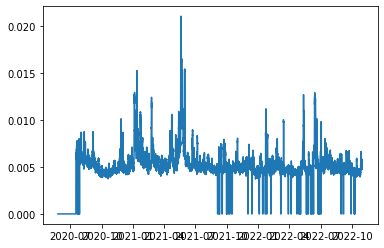

In [ ]:
plt.plot(df['timestamp'],df['volatility'])

In [ ]:
df.shape

(127690, 10)

### MLP

In [ ]:
train_start = '2020-05-26'
train_end = '2022-07-31'
dev_start = '2022-08-01'
dev_end = '2022-09-30'
test_start = '2022-10-01'
test_end = '2022-10-31'

In [ ]:
train_dates = df[((df['timestamp'] >= train_start) & (df['timestamp'] <= train_end))]['volatility'].values.reshape((-1,1))
dev_dates = df[((df['timestamp'] >= dev_start) & (df['timestamp'] <= dev_end))]['volatility'].values.reshape((-1,1))
test_dates = df[((df['timestamp'] >= test_start) & (df['timestamp'] <= test_end))]['volatility'].values.reshape((-1,1))
train_dates.shape, dev_dates.shape, test_dates.shape

((114499, 1), (8641, 1), (4264, 1))

In [ ]:
# univariate mlp example
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
raw_seq = train_dates
# choose a number of time steps
days_look_back = 14
n_steps = 24*6*days_look_back
# split into samples
X, y = split_sequence(raw_seq, n_steps)

# define model
model = Sequential()
model.add(Dense(8, activation='relu', input_dim=n_steps))
#model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredLogarithmicError())

# fit model
num_epochs = 100
history = model.fit(X, y, epochs=num_epochs)

Epoch 1/100
3516/3516 [==============================] - 17s 5ms/step - loss: 3.5718e-07
Epoch 2/100
3516/3516 [==============================] - 12s 3ms/step - loss: 1.4369e-07
Epoch 3/100
3516/3516 [==============================] - 8s 2ms/step - loss: 1.1332e-07
Epoch 4/100
3516/3516 [==============================] - 9s 3ms/step - loss: 9.9912e-08
Epoch 5/100
3516/3516 [==============================] - 8s 2ms/step - loss: 8.7107e-08
Epoch 6/100
3516/3516 [==============================] - 8s 2ms/step - loss: 8.2086e-08
Epoch 7/100
3516/3516 [==============================] - 8s 2ms/step - loss: 7.5968e-08
Epoch 8/100
3516/3516 [==============================] - 9s 3ms/step - loss: 7.2523e-08
Epoch 9/100
3516/3516 [==============================] - 10s 3ms/step - loss: 6.7824e-08
Epoch 10/100
3516/3516 [==============================] - 8s 2ms/step - loss: 6.8174e-08
Epoch 11/100
3516/3516 [==============================] - 8s 2ms/step - loss: 6.3174e-08
Epoch 12/100
3516/3516 [===

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8)                 16136     
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 16,145
Trainable params: 16,145
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_save_name = 'MLP8baseline_ep100_back14_rollvol_logMSE'
model.save('/content/gdrive/My Drive/CS230proj/model_{}.h5'.format(model_save_name))

In [ ]:
#import tensorflow as tf
#from tensorflow import keras
#new_model = tf.keras.models.load_model('/content/gdrive/My Drive/CS230proj/model_{}.h5'.format(model_save_name))

# Check its architecture
#new_model.summary()

In [ ]:
# demonstrate prediction
X_dev, y_dev = split_sequence(dev_dates, n_steps)
X_dev = X_dev.reshape((X_dev.shape[0], n_steps))
y_dev_pred = model.predict(X_dev)
y_train_pred = model.predict(X.reshape((X.shape[0], n_steps)))
print(y_dev_pred.shape, y_train_pred.shape)

3516/3516 [==============================] - 5s 1ms/step
(6625, 1) (112483, 1)


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_dev_pred, dev_dates[24*6*days_look_back:])

0.13302465429895377

In [ ]:
mean_absolute_percentage_error(y_train_pred, train_dates[24*6*days_look_back:])